In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np  
import os 
import argparse
import torch 
from torch.autograd import Variable
import torchvision.transforms as transforms
import random
from torch.utils.data import DataLoader
from torchvision import datasets 
import torch.nn as nn
import torch.nn.functional as F 
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image

In [ ]:
batchSize = 64
imageSize = 70
channels = 3
latentdim = 100
n_classes = 5
epochs= 40
lrate = 0.0002
beta = 0.5
beta1 = 0.999
output = '.'

In [8]:
class GetData(Dataset):
    def __init__(self, Dir, FNames, Labels, Transform):
        self.dir = Dir
        self.fnames = FNames
        self.transform = Transform
        self.lbs = Labels
        
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):
        x = Image.open(os.path.join(self.dir, self.fnames[index]))
        if "train" in self.dir:            
            return self.transform(x), self.lbs[index]            
        elif "test" in self.dir:            
            return self.transform(x), self.fnames[index]

In [24]:
img_shape = (channels, imageSize, imageSize)

cuda = True if torch.cuda.is_available() else False 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.makedirs(output, exist_ok=True)

randomseed = random.randint(1,10000)
random.seed(randomseed)
torch.manual_seed(randomseed)


df_train = pd.read_csv("/content/gdrive/MyDrive/input/cassava-leaf-disease-classification/train.csv")
df_train.head()
X_Train, Y_Train = df_train['image_id'].values, df_train['label'].values

print(len(X_Train))
Transform = transforms.Compose(
  [transforms.ToTensor(),
  transforms.Resize((imageSize, imageSize)),
  transforms.RandomRotation(90),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_image_paths = "/content/gdrive/MyDrive/input/cassava-leaf-disease-classification/train_images/"

dataset = GetData(train_image_paths, X_Train, Y_Train, Transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True)
print('data loader has done its job!')


21397
data loader has done its job!


In [25]:
class Generator(nn.Module): 
	def __init__(self):
		super(Generator, self).__init__()
		self.label_embed = nn.Embedding(n_classes, n_classes)
		self.depth=128

		def init(input, output, normalize=True): 
			layers = [nn.Linear(input, output)]
			layers.append(nn.BatchNorm1d(output, 0.8))
			layers.append(nn.LeakyReLU(0.2, inplace=True))
			return layers 

		self.generator = nn.Sequential(
			*init(latentdim+n_classes, self.depth), 
			*init(128, 256), 
			*init(256, 512), 
			*init(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
           
			)

	def forward(self, noise, labels): 
		gen_input = torch.cat((self.label_embed(labels), noise), -1)
		img = self.generator(gen_input)
		img = img.view(img.size(0), *img_shape)
		return img





In [ ]:
class Discriminator(nn.Module): 
	def __init__(self): 
		super(Discriminator, self).__init__()
		self.label_embed1 = nn.Embedding(n_classes, n_classes)
		self.dropout = 0.4 
		self.depth = 512

		def init(input, output, normalize=True): 
			layers = [nn.Linear(input, output)]
			if normalize: 
				layers.append(nn.Dropout(self.dropout))
			layers.append(nn.LeakyReLU(0.2, inplace=True))
			return layers 

		self.discriminator = nn.Sequential(
			*init(n_classes+int(np.prod(img_shape)), 512, normalize=False),
			*init(512, 512), 
			*init(512, 512),
			nn.Linear(512, 1),
			nn.Sigmoid()
			)

	def forward(self, img, labels): 
		imgs = img.view(img.size(0),-1)
		inpu = torch.cat((imgs, self.label_embed1(labels)), -1)
		validity = self.discriminator(inpu)
		return validity 

def init_weights(m): 
	if type(m)==nn.Linear:
		torch.nn.init.xavier_uniform(m.weight)
		m.bias.data.fill_(0.01)
	


In [ ]:

generator = Generator()
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lrate, betas=(beta, beta1)) 
discriminator = Discriminator()
discriminator.apply(init_weights)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lrate, betas=(beta, beta1))


a_loss = torch.nn.BCELoss()


real_label = 0.9
fake_label = 0.0

FT = torch.LongTensor
FT_a = torch.FloatTensor

if cuda: 
	generator.cuda()
	discriminator.cuda()
	a_loss.cuda()
	FT = torch.cuda.LongTensor
	FT_a = torch.cuda.FloatTensor



In [ ]:
for epoch in range(epochs): 
  print(epoch)
  for i, (images, labels) in enumerate(dataloader):
    print('hi')
    batch_size = images.shape[0]

    
    images = Variable(images.type(FT_a))
    labels = Variable(labels.type(FT))
    reall = Variable(FT_a(batch_size,1).fill_(real_label))
    f_label = Variable(FT_a(batch_size,1).fill_(fake_label))


    gen_optimizer.zero_grad() 
    d_optimizer.zero_grad() 
    noise = Variable(FT_a(np.random.normal(0, 1,(batch_size, latentdim))))
    gen_labels = Variable(FT(np.random.randint(0, n_classes, batch_size)))

    gen_imgs = generator(noise, gen_labels)
    validity = discriminator(gen_imgs, gen_labels)
    g_loss = a_loss(validity, reall)

 
    g_loss.backward()
    gen_optimizer.step()
    d_optimizer.zero_grad()
    validity_real = discriminator(imgs, labels)
    d_real_loss = a_loss(validity_real, reall)
    validity_fake = discriminator(gen_imgs.detach(), gen_labels)
    d_fake_loss = a_loss(validity_fake, f_label)
    d_loss = 0.5 * (d_fake_loss+d_real_loss)
    d_loss.backward()
    d_optimizer.step()
  print("[Epoch: %d/%d]" "[D loss: %f]" "[G loss: %f]" % (epoch+1, epochs, d_loss.item(), g_loss.item()))
  print('hi')



In [42]:
torch.save(generator.state_dict(), 'generator.pth')

In [55]:
noise = Variable(FT_a(np.random.normal(0, 1,(10, latentdim))))
gen_labels = Variable(FT(np.random.randint(0, n_classes, 10)))
print(gen_labels[0])
fake = generator(noise, gen_labels)
print(fake.shape)
vutils.save_image(fake[0].detach(), 'fake.png' , normalize=True)

tensor(2, device='cuda:0')
torch.Size([10, 3, 70, 70])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


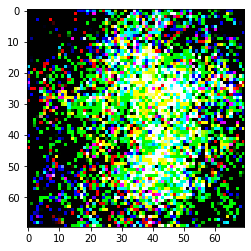

In [56]:
from matplotlib import pyplot as plt
plt.imshow(fake[0].detach().cpu().permute(1, 2 ,0))

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 2, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(625*2, 1024)
        self.fc2 = nn.Linear(1024, 5)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x
